# Hyperparameter Tuning

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm
from lightgbm import LGBMRegressor
from itertools import product

In [2]:
import dill

In [3]:
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="X does not have valid feature names")
warnings.filterwarnings("ignore", message="DataFrame.fillna with 'method' is deprecated")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 

In [5]:
tqdm.pandas()

## Load Data

In [6]:
week = 'w02'

In [7]:
# input_2023 = pd.read_csv(f'../data/train/input_2023_{week}_subset.csv')
input_2023 = pd.read_csv(f'../data/train/input_2023_{week}.csv')
# input_2023 = pd.read_csv(f'../data/folds/fold1/TRAIN_input.csv')

In [8]:
# output_2023 = pd.read_csv(f'../data/train/output_2023_{week}_subset.csv')
output_2023 = pd.read_csv(f'../data/train/output_2023_{week}.csv')
# output_2023 = pd.read_csv(f'../data/folds/fold1/TRAIN_output.csv')

In [13]:
input_2023.shape

(288586, 23)

In [14]:
output_2023.shape

(32180, 6)

## Merge Input and Output

In [15]:
def merge_input_output_df(input_df, output_df):
    keys = ['game_id', 'play_id', 'nfl_id']
    
    # Identify missing columns in output csv
    missing_output_cols = [col for col in input_df.columns if col not in output_df.columns]
    
    # Set a default value of `np.nan` for those missing fields.
    for col in missing_output_cols:
        output_df[col] = np.nan
        
    # Add a source column to identify the origin of each record
    input_df['source'] = 'input'
    output_df['source'] = 'output'
    
    # Stack dataframes vertically
    combined_df = pd.concat([input_df, output_df], ignore_index=True)
    
    # Sort by keys and source so that the we can forward fill appropriately.
    combined_df = combined_df.sort_values(by=keys + ['source'], ascending=[True]*4)
    
    # Forward fill the missing fields in the output records using the values from the input.
    combined_df[input_df.columns] = combined_df.groupby(keys)[input_df.columns].ffill()
    
    # Reset index
    combined_df.reset_index(drop=True, inplace=True)
    
    return combined_df

In [16]:
combined_df = merge_input_output_df(input_2023, output_2023)

In [17]:
combined_df.shape

(320766, 24)

## Standardize XY Positions

In [18]:
def standardize_by_play_direction(df):
    # Standardize X-Y Position
    df.loc[df['play_direction'] == 'left', 'x'] = 120 - df['x']
    df.loc[df['play_direction'] == 'left', 'ball_land_x'] = 120 - df['ball_land_x']
    df.loc[df['play_direction'] == 'left', 'y'] = 53.3 - df['y']
    df.loc[df['play_direction'] == 'left', 'ball_land_y'] = 53.3 - df['ball_land_y']
    
    # Standardize 'dir' and 'o' angles
    df.loc[df['play_direction'] == 'left', 'dir'] = (df['dir'] + 180) % 360
    df.loc[df['play_direction'] == 'left', 'o'] = (df['o'] + 180) % 360
    
    return df

In [19]:
std_df = standardize_by_play_direction(combined_df)

In [20]:
std_df.shape

(320766, 24)

## Engineer Features

Previously, we used features that made simplifications to the models:
1. For the offense, we assumed that is affected by the closest defender only
2. For the defense, we assumed that a defender is affected by the receiver only and not by the other defenders

Despite this, the model for the offense did quite well. However, the defense resulted in poorer predictions. And this is expected for the defense since they technically play as a "system". In this model, for each player, we will include features that aggregate important info that relates to all the other players in the field. Specifically, we include the following features. The labels at the start tell us if the feature is present for _all_ or the _def_ or _off_ only.

- Features that describe the player itself
1. _[all]_   velocity x & y (2)
2. _[all]_   acceleration x & y (2)
3. _[all]_   land spot bearing (x, y, r) (3)
4. _[all]_   distance from top (1)
5. _[all]_   distance from endzone (1)

- Features that describe the other players
1. _[def]_   bearing to offensive player (x, y, r) (3)
2. _[def]_   receiver velocity x & y (2)
3. _[def]_   receiver acceleration x & y (2)
4. _[off]_   bearing to closest defender (x, y, r) (3)
5. _[off]_   closest defender velocity x & y (2)
6. _[off]_   closest defender acceleration x & y (2)
7. _[all]_   mean, std, skewness, kurtosis of positive distances x & y (i.e. the defense players ahead and above the described player) (8)
8. _[all]_   mean, std, skewness, kurtosis of negative distances x & y (i.e. the defense players behind and below the described player) (8)

- Other features
1. _[all]_   throw distance
2. _[all]_   throw velocity

In [21]:
def vectorize_kinematics(df: pd.DataFrame):
    groups = ['game_id', 'play_id', 'nfl_id']

    df['x_shift'] = df.groupby(groups)['x'].shift(1)
    df['y_shift'] = df.groupby(groups)['y'].shift(1)

    df['velocity_x'] = (df['x'] - df['x_shift']) / 0.1
    df['velocity_y'] = (df['y'] - df['y_shift']) / 0.1

    df['acc_x'] = df.groupby(groups)['velocity_x'].diff() / 0.1
    df['acc_y'] = df.groupby(groups)['velocity_y'].diff() / 0.1

    return df

In [22]:
def calculate_land_spot_bearing(df: pd.DataFrame):
    # Receiver angle to landing spot
    df['land_spot_dir'] = np.degrees(np.arctan2(
        df['ball_land_y'] - df['y'],
        df['ball_land_x'] - df['x']
    )) % 360
    
    # xy components for angle to landing spot
    df['land_spot_dirx'] = np.cos(np.radians(df['land_spot_dir']))
    df['land_spot_diry'] = np.sin(np.radians(df['land_spot_dir']))
    
    # landing spot distance
    df['land_spot_dist'] = np.sqrt(
        (df['ball_land_x'] - df['x'])**2 + (df['ball_land_y'] - df['y'])**2
    )
    
    return df

In [23]:
def calculate_field_distances(df: pd.DataFrame):
    # Distance from top
    df['dist_sideline'] = 53.3 - df['y']
    
    # Distance to nearest endzone
    df['dist_endzone'] = 120 - df['x']
    
    return df

In [24]:
def get_closest_defender_bearing(df: pd.DataFrame):
    def closest(group: pd.DataFrame):
        # exactly 1 offensive player
        off = group[group['player_role'] == 'Targeted Receiver'].iloc[0]

        # all defenders
        defs = group[group['player_side'] == 'Defense']

        if defs.empty:
            return pd.Series({
                'nfl_id': off.nfl_id,
                'closest_def_id': -1,
                'closest_def_dist': 0,
                'closest_def_dir_x': 0,
                'closest_def_dir_y': 0
            })

        # Get x, y directions from offense to each defender
        closest_def_dir = np.degrees(np.arctan2(defs['y'] - off['y'], defs['x'] - off['x'])) % 360
        closest_def_dir_x = np.cos(np.radians(closest_def_dir))
        closest_def_dir_y = np.sin(np.radians(closest_def_dir))
        
        # compute Euclidean distances
        closest_def_dist = np.sqrt((defs['x'] - off['x'])**2 + (defs['y'] - off['y'])**2)

        # index of defender with min distance
        idxmin = closest_def_dist.idxmin()
        
        return pd.DataFrame([{
            'nfl_id': off.nfl_id,
            'closest_def_id': defs.loc[idxmin, 'nfl_id'],
            'closest_def_dist': closest_def_dist.loc[idxmin],
            'closest_def_dir_x': closest_def_dir_x.loc[idxmin],
            'closest_def_dir_y': closest_def_dir_y.loc[idxmin]
        }])

    result = (
        df.groupby(['game_id', 'play_id', 'frame_id', 'source'])
        .apply(closest)
        .reset_index()
        # .drop(['level_4'])
    )
    
    # Merge back to original dataframe
    merged = df.merge(
        result,
        on=['game_id', 'play_id', 'frame_id', 'source', 'nfl_id'],
        how='left',
        suffixes=['', '_y']
    )

    # Identify offense rows
    mask = df['player_side'] == 'Offense'

    # Keep merged values only for offense rows
    for col in result.columns:
        if col not in ['game_id', 'play_id', 'frame_id', 'source', 'nfl_id']:
            merged[col] = merged[col].where(mask)
    
    return merged

In [25]:
def get_closest_defender_kinematics(df: pd.DataFrame):
    def closest(group: pd.DataFrame):
        # exactly 1 offensive player
        off = group[group['player_role'] == 'Targeted Receiver'].iloc[0]

        # all defenders
        defs = group[group['player_side'] == 'Defense']

        if defs.empty:
            return pd.Series({
                'nfl_id': off.nfl_id,
                'closest_def_id': -1,
                'closest_def_velo_x': 0,
                'closest_def_velo_y': 0,
                'closest_def_acc_x': 0,
                'closest_def_acc_y': 0
            })
        
        # Get velocities and acceleration
        closest_def_velo_x, closest_def_velo_y = defs['velocity_x'], defs['velocity_y']
        closest_def_acc_x, closest_def_acc_y = defs['acc_x'], defs['acc_y']
        
        # compute Euclidean distances
        closest_def_dist = np.sqrt((defs['x'] - off['x'])**2 + (defs['y'] - off['y'])**2)
        
        # index of defender with min distance
        idxmin = closest_def_dist.idxmin()
        
        return pd.DataFrame([{
            'nfl_id': off.nfl_id,
            'closest_def_id': defs.loc[idxmin, 'nfl_id'],
            'closest_def_velo_x': closest_def_velo_x.loc[idxmin],
            'closest_def_velo_y': closest_def_velo_y.loc[idxmin],
            'closest_def_acc_x': closest_def_acc_x.loc[idxmin],
            'closest_def_acc_y': closest_def_acc_y.loc[idxmin]
        }])
        
    
    result = (
        df.groupby(['game_id', 'play_id', 'frame_id', 'source'])
        .apply(closest)
        .reset_index()
        # .drop(['level_4'])
    )
    
    # Merge back to original dataframe
    merged = df.merge(
        result,
        on=['game_id', 'play_id', 'frame_id', 'source', 'nfl_id'],
        how='left',
        suffixes=['', '_y']
    )
    
    # Identify offense rows
    mask = df['player_side'] == 'Offense'

    # Keep merged values only for offense rows
    for col in result.columns:
        if col not in ['game_id', 'play_id', 'frame_id', 'source', 'nfl_id']:
            merged[col] = merged[col].where(mask)
    
    return merged

In [26]:
def get_receiver_bearing(df: pd.DataFrame):
    off = (
        df[df['player_role'] == 'Targeted Receiver']
        [['game_id', 'play_id', 'frame_id', 'source', 'player_side', 'nfl_id', 'x', 'y']]
    )
    
    defs = df[df['player_side'] == 'Defense']
    
    df2 = defs.merge(
        off,
        on=['game_id', 'play_id', 'frame_id', 'source'],
        how='left',
        suffixes=('', '_off')
    )
    
    # Get x, y directions from defender to receiver
    receiver_dir = np.degrees(np.arctan2(df2['y_off'] - df2['y'], df2['x_off'] - df2['x'])) % 360
    receiver_dir_x = np.cos(np.radians(receiver_dir))
    receiver_dir_y = np.sin(np.radians(receiver_dir))
    
    # Calculate receiver distance
    df2['receiver_dist'] = np.sqrt(
        (df2['x'] - df2['x_off'])**2 +
        (df2['y'] - df2['y_off'])**2
    )
    
    result = df2[['game_id', 'play_id', 'frame_id', 'source', 'nfl_id', 'receiver_dist']].copy()
    result['receiver_dir_x'] = receiver_dir_x
    result['receiver_dir_y'] = receiver_dir_y
    
    merged = df.merge(
        result,
        on=['game_id', 'play_id', 'frame_id', 'source', 'nfl_id'],
        how='left',
        suffixes=['', '_y']
    )
    
    return merged

In [27]:
def get_receiver_kinematics(df: pd.DataFrame):
    off = (
        df[df['player_role'] == 'Targeted Receiver']
        [['game_id', 'play_id', 'frame_id', 
          'source', 'player_side', 'nfl_id', 
          'velocity_x', 'velocity_y',
          'acc_x', 'acc_y'
        ]]
    )
    
    defs = df[df['player_side'] == 'Defense']
    
    df2 = defs.merge(
        off,
        on=['game_id', 'play_id', 'frame_id', 'source'],
        how='left',
        suffixes=('', '_off')
    )
    
    result = df2[['game_id', 'play_id', 'frame_id', 'source', 'nfl_id', 'velocity_x_off', 'velocity_y_off', 'acc_x_off', 'acc_y_off']]
    
    merged = df.merge(
        result,
        on=['game_id', 'play_id', 'frame_id', 'source', 'nfl_id'],
        how='left',
        suffixes=['', '_y']
    )
    
    return merged

In [28]:
# # Calculate moments features for positive and negative locations
# def calculate_moments(df: pd.DataFrame):
#     def moments(group: pd.DataFrame):        
#         comp_df = group.merge(group, on=['game_id', 'play_id', 'source', 'frame_id'], suffixes=('', '_M'))
#         comp_df = comp_df[comp_df.nfl_id != comp_df.nfl_id_M]  # Exclude self-comparison
#         comp_df = comp_df[comp_df.player_side_M != 'Offense']  # Exclude if comparison is against offense
#         comp_df['x_dist'] = comp_df['x_M'] - comp_df['x']
#         comp_df['y_dist'] = comp_df['y_M'] - comp_df['y']
        
#         out = (
#             comp_df.groupby(['game_id', 'play_id', 'source', 'frame_id', 'nfl_id'])
#             .agg(
#                 num_x_pos_dist=('x_dist', lambda s: (s >= 0).sum()),
#                 mean_x_pos_dist=('x_dist', lambda s: s[s >= 0].mean()),
#                 var_x_pos_dist=('x_dist', lambda s: s[s >= 0].var()),
#                 skew_x_pos_dist=('x_dist', lambda s: s[s >= 0].skew()),
#                 kurt_x_pos_dist=('x_dist', lambda s: s[s >= 0].kurtosis()),

#                 num_x_neg_dist=('x_dist', lambda s: (s < 0).sum()),
#                 mean_x_neg_dist=('x_dist', lambda s: s[s < 0].mean()),
#                 var_x_neg_dist=('x_dist', lambda s: s[s < 0].var()),
#                 skew_x_neg_dist=('x_dist', lambda s: s[s < 0].skew()),
#                 kurt_x_neg_dist=('x_dist', lambda s: s[s < 0].kurtosis()),

#                 num_y_pos_dist=('y_dist', lambda s: (s >= 0).sum()),
#                 mean_y_pos_dist=('y_dist', lambda s: s[s >= 0].mean()),
#                 var_y_pos_dist=('y_dist', lambda s: s[s >= 0].var()),
#                 skew_y_pos_dist=('y_dist', lambda s: s[s >= 0].skew()),
#                 kurt_y_pos_dist=('y_dist', lambda s: s[s >= 0].kurtosis()),

#                 num_y_neg_dist=('y_dist', lambda s: (s < 0).sum()),
#                 mean_y_neg_dist=('y_dist', lambda s: s[s < 0].mean()),
#                 var_y_neg_dist=('y_dist', lambda s: s[s < 0].var()),
#                 skew_y_neg_dist=('y_dist', lambda s: s[s < 0].skew()),
#                 kurt_y_neg_dist=('y_dist', lambda s: s[s < 0].kurtosis()),
#             )
#             .reset_index()
#         )
        
#         return out

#     result = (
#         df.groupby(['game_id', 'play_id', 'frame_id', 'source'], as_index=False)
#         .progress_apply(moments)
#         .fillna(0)
#         .reset_index()
#     )

#     return result
    
#     # merged = df.merge(
#     #     result,
#     #     on=['game_id', 'play_id', 'frame_id', 'nfl_id', 'source'],
#     #     how='left',
#     # )
    
#     # return merged

In [29]:
def calculate_moments(df: pd.DataFrame):
    results = []

    # group by frame
    for (gid, pid, sid, fid), group in df.groupby(
        ['game_id','play_id','source','frame_id']
    ):
        out_rows = []
        
        # Extract arrays
        nfl_ids = group['nfl_id'].values               # players of interest
        x = group['x'].values
        y = group['y'].values
        
        # Only compare to defenders (player_side == Defense)
        defenders = group[group.player_side == "Defense"]
        
        if defenders.empty:
            out_rows.append({
                'game_id': gid,
                'play_id': pid,
                'source': sid,
                'frame_id': fid,
                'nfl_id': group['nfl_id'].values[0],
                
                'num_x_pos_dist': 0,
                'mean_x_pos_dist': 0,
                'var_x_pos_dist': 0,
                'skew_x_pos_dist': 0,
                'kurt_x_pos_dist': 0,

                'num_x_neg_dist': 0,
                'mean_x_neg_dist': 0,
                'var_x_neg_dist': 0,
                'skew_x_neg_dist': 0,
                'kurt_x_neg_dist': 0,

                'num_y_pos_dist': 0,
                'mean_y_pos_dist': 0,
                'var_y_pos_dist': 0,
                'skew_y_pos_dist': 0,
                'kurt_y_pos_dist': 0,

                'num_y_neg_dist': 0,
                'mean_y_neg_dist': 0,
                'var_y_neg_dist': 0,
                'skew_y_neg_dist': 0,
                'kurt_y_neg_dist': 0,
            })
            
            results.extend(out_rows)
            
            continue

        def_nfl_ids = defenders['nfl_id'].values       # defenders to compare against
        dx = defenders['x'].values
        dy = defenders['y'].values

        # --- VECTORIZED BROADCASTING ---
        # shape: (num_players, num_defenders)
        x_dist = dx[None, :] - x[:, None]
        y_dist = dy[None, :] - y[:, None]
        
        # --- compute stats for each player ---
        for i, player_id in enumerate(nfl_ids):
            # If x_dist / y_dist is 0, then it is self-comparison - exclude these
            xd = np.array([f for f in x_dist[i] if f != 0])
            yd = np.array([f for f in y_dist[i] if f != 0])

            # positive/negative masks
            xp = xd[xd >= 0]; xn = xd[xd < 0]
            yp = yd[yd >= 0]; yn = yd[yd < 0]

            out_rows.append({
                'game_id': gid,
                'play_id': pid,
                'source': sid,
                'frame_id': fid,
                'nfl_id': player_id,

                'num_x_pos_dist': len(xp),
                'mean_x_pos_dist': xp.mean() if len(xp) else 0,
                'var_x_pos_dist': xp.var(ddof=1) if len(xp) > 1 else 0,
                'skew_x_pos_dist': pd.Series(xp).skew() if len(xp) > 2 else 0,
                'kurt_x_pos_dist': pd.Series(xp).kurtosis() if len(xp) > 3 else 0,

                'num_x_neg_dist': len(xn),
                'mean_x_neg_dist': xn.mean() if len(xn) else 0,
                'var_x_neg_dist': xn.var(ddof=1) if len(xn) > 1 else 0,
                'skew_x_neg_dist': pd.Series(xn).skew() if len(xn) > 2 else 0,
                'kurt_x_neg_dist': pd.Series(xn).kurtosis() if len(xn) > 3 else 0,

                'num_y_pos_dist': len(yp),
                'mean_y_pos_dist': yp.mean() if len(yp) else 0,
                'var_y_pos_dist': yp.var(ddof=1) if len(yp) > 1 else 0,
                'skew_y_pos_dist': pd.Series(yp).skew() if len(yp) > 2 else 0,
                'kurt_y_pos_dist': pd.Series(yp).kurtosis() if len(yp) > 3 else 0,

                'num_y_neg_dist': len(yn),
                'mean_y_neg_dist': yn.mean() if len(yn) else 0,
                'var_y_neg_dist': yn.var(ddof=1) if len(yn) > 1 else 0,
                'skew_y_neg_dist': pd.Series(yn).skew() if len(yn) > 2 else 0,
                'kurt_y_neg_dist': pd.Series(yn).kurtosis() if len(yn) > 3 else 0,
            })

        results.extend(out_rows)
    
    try:
        moments = pd.DataFrame(results)
        df = df.merge(moments, on=['game_id', 'play_id', 'frame_id', 'nfl_id', 'source'], how='left')
    except:
        print(nfl_ids)
        print(results)
        raise ValueError

    return df

In [30]:
# def calculate_moments(df: pd.DataFrame):
#     def moments_for_frame(frame_group: pd.DataFrame):
#         # arrays
#         nfl_ids = frame_group['nfl_id'].values
#         xs = frame_group['x'].values
#         ys = frame_group['y'].values
#         sides = frame_group['player_side'].values  # "Offense" / "Defense"

#         # mask of defenders
#         defense_mask = (sides == "Defense")
#         xs_def = xs[defense_mask]
#         ys_def = ys[defense_mask]
#         nfl_def_ids = nfl_ids[defense_mask]

#         n = len(nfl_ids)
#         out_rows = []

#         # Loop over every focal player i
#         for i in range(n):
#             focal_id = nfl_ids[i]
#             focal_x = xs[i]
#             focal_y = ys[i]

#             # If no defenders exist, everything will be empty
#             if xs_def.size == 0:
#                 out_rows.append({
#                     'game_id': frame_group['game_id'].iat[0],
#                     'play_id': frame_group['play_id'].iat[0],
#                     'frame_id': frame_group['frame_id'].iat[0],
#                     'source': frame_group['source'].iat[0],
#                     'nfl_id': focal_id,
#                     **{k: 0 for k in [
#                         'num_x_pos_dist','mean_x_pos_dist','var_x_pos_dist','skew_x_pos_dist','kurt_x_pos_dist',
#                         'num_x_neg_dist','mean_x_neg_dist','var_x_neg_dist','skew_x_neg_dist','kurt_x_neg_dist',
#                         'num_y_pos_dist','mean_y_pos_dist','var_y_pos_dist','skew_y_pos_dist','kurt_y_pos_dist',
#                         'num_y_neg_dist','mean_y_neg_dist','var_y_neg_dist','skew_y_neg_dist','kurt_y_neg_dist'
#                     ]}
#                 })
#                 continue

#             # dx, dy vs defenders only
#             dx = xs_def - focal_x
#             dy = ys_def - focal_y

#             # If focal player is defense, remove self-comparison
#             if sides[i] == "Defense":
#                 # find where nfl_ids match
#                 self_mask = nfl_def_ids != focal_id
#                 dx = dx[self_mask]
#                 dy = dy[self_mask]

#             # convert to Series
#             sx = pd.Series(dx)
#             sy = pd.Series(dy)

#             x_pos = sx[sx >= 0]
#             x_neg = sx[sx < 0]
#             y_pos = sy[sy >= 0]
#             y_neg = sy[sy < 0]

#             def stats(s):
#                 if s.size == 0:
#                     return 0, 0.0, 0.0, 0.0, 0.0
                
#                 variance = s.var(ddof=0)
#                 skewness = s.skew()
#                 kurtosis = s.kurtosis()
                
#                 if np.isnan(variance):
#                     variance = 0.0
                
#                 if np.isnan(skewness):
#                     skewness = 0.0
                    
#                 if np.isnan(kurtosis):
#                     kurtosis = 0.0
                
#                 return len(s), s.mean(), variance, skewness, kurtosis

#             num_x_pos, mean_x_pos, var_x_pos, skew_x_pos, kurt_x_pos = stats(x_pos)
#             num_x_neg, mean_x_neg, var_x_neg, skew_x_neg, kurt_x_neg = stats(x_neg)
#             num_y_pos, mean_y_pos, var_y_pos, skew_y_pos, kurt_y_pos = stats(y_pos)
#             num_y_neg, mean_y_neg, var_y_neg, skew_y_neg, kurt_y_neg = stats(y_neg)

#             out_rows.append({
#                 'game_id': frame_group['game_id'].iat[0],
#                 'play_id': frame_group['play_id'].iat[0],
#                 'frame_id': frame_group['frame_id'].iat[0],
#                 'source': frame_group['source'].iat[0],
#                 'nfl_id': focal_id,

#                 'num_x_pos_dist': num_x_pos,
#                 'mean_x_pos_dist': mean_x_pos,
#                 'var_x_pos_dist': var_x_pos,
#                 'skew_x_pos_dist': skew_x_pos,
#                 'kurt_x_pos_dist': kurt_x_pos,

#                 'num_x_neg_dist': num_x_neg,
#                 'mean_x_neg_dist': mean_x_neg,
#                 'var_x_neg_dist': var_x_neg,
#                 'skew_x_neg_dist': skew_x_neg,
#                 'kurt_x_neg_dist': kurt_x_neg,

#                 'num_y_pos_dist': num_y_pos,
#                 'mean_y_pos_dist': mean_y_pos,
#                 'var_y_pos_dist': var_y_pos,
#                 'skew_y_pos_dist': skew_y_pos,
#                 'kurt_y_pos_dist': kurt_y_pos,

#                 'num_y_neg_dist': num_y_neg,
#                 'mean_y_neg_dist': mean_y_neg,
#                 'var_y_neg_dist': var_y_neg,
#                 'skew_y_neg_dist': skew_y_neg,
#                 'kurt_y_neg_dist': kurt_y_neg,
#             })

#         return pd.DataFrame(out_rows)
    
#     result = (
#         df.groupby(['game_id', 'play_id', 'frame_id', 'source'], sort=False)
#         .progress_apply(moments_for_frame)
#         .reset_index(drop=True)
#     )

#     return df.merge(
#         result,
#         on=['game_id', 'play_id', 'frame_id', 'nfl_id', 'source'],
#         how='left',
#         suffixes=['', '_y']
#     )

In [31]:
def calculate_throw_stats(df):
    # Create a small df with throw distance and throw velocity per game_id, play_id
    qb_df = df[df['player_position'] == 'QB']
    qb_df = qb_df.drop_duplicates(subset=['game_id', 'play_id'], keep='last')
    
    qb_df['throw_distance'] = np.sqrt((qb_df['ball_land_x'] - qb_df['x'])**2 + (qb_df['ball_land_y'] - qb_df['y'])**2)
    qb_df['throw_velocity'] = qb_df['throw_distance'] / (qb_df['num_frames_output'] / 10)
    throw_stats_df = qb_df[['game_id', 'play_id', 'throw_distance', 'throw_velocity']]
    
    return throw_stats_df

In [32]:
throw_stats = calculate_throw_stats(std_df)

In [33]:
std_df_subset = std_df[std_df['player_to_predict'] == True].reset_index(drop=True)

In [34]:
eng_df = std_df_subset.copy()

In [35]:
eng_df.shape

(108086, 24)

In [36]:
eng_df = vectorize_kinematics(eng_df)

In [37]:
eng_df.shape

(108086, 30)

In [38]:
# # Clear some memory
# del std_df_subset
# del input_2023
# del output_2023

In [39]:
eng_df = calculate_field_distances(eng_df)

In [40]:
eng_df.shape

(108086, 32)

In [41]:
eng_df = calculate_land_spot_bearing(eng_df)

In [42]:
eng_df.shape

(108086, 36)

In [43]:
eng_df = get_closest_defender_bearing(eng_df).drop(['level_4', 0], axis=1)  # Where do this column 0 come from????

In [44]:
eng_df.shape

(108086, 40)

In [45]:
eng_df = get_closest_defender_kinematics(eng_df).drop(['level_4', 0], axis=1)  # Where do this column 0 come from????

In [46]:
eng_df.shape

(108086, 45)

In [47]:
eng_df = get_receiver_bearing(eng_df)

In [48]:
eng_df.shape

(108086, 48)

In [49]:
eng_df = get_receiver_kinematics(eng_df)

In [50]:
eng_df.shape

(108086, 52)

In [51]:
eng_df = calculate_moments(eng_df)

In [52]:
eng_df.shape

(108086, 72)

In [53]:
eng_df = eng_df.merge(throw_stats, on=['game_id', 'play_id'], how='left')

In [54]:
eng_df.shape

(108086, 74)

In [55]:
eng_df[eng_df[['mean_x_pos_dist']].isnull().any(axis=1)].shape

(0, 74)

There are some instances where there's only the receiver to predict! Hence, the moments features get a `NaN` value. In these instances, we just fill it with 0s. Whether this is the right choice or not, I don't know.

In [56]:
eng_df.fillna(0, inplace=True)

## Tuning

In [58]:
def reduce_df(df: pd.DataFrame):
    # Get all frames in output and last frame of input
    df = df[((df.source == 'input') & (df.frame_id == df[df.source == 'input'].frame_id.max())) | (df.source == 'output')]
    df.loc[df.source == 'input', 'frame_id'] = 0
    
    return df

In [59]:
def append_values_to_predict(df: pd.DataFrame):
    df['velocity_x_shift'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['velocity_x'].shift(-1)
    df['velocity_y_shift'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['velocity_y'].shift(-1)
    df['acceleration_x_shift'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['acc_x'].shift(-1)
    df['acceleration_y_shift'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['acc_y'].shift(-1)
    
    return df

In [60]:
def fit_and_scale_features(X: pd.DataFrame, y:pd.DataFrame):
    motion_vars = ['velocity_x', 'velocity_y', 'acc_x', 'acc_y']
    other_vars = [col for col in X.columns if col not in motion_vars]
    
    y = y.rename(columns={
        'velocity_x_shift': 'velocity_x',
        'velocity_y_shift': 'velocity_y',
        'acceleration_x_shift': 'acc_x',
        'acceleration_y_shift': 'acc_y'
    })
    
    scaler_motion = StandardScaler()
    scaler_others = StandardScaler()
    
    # Apply scaling
    X_motion_scaled = pd.DataFrame(scaler_motion.fit_transform(X[motion_vars]), columns=motion_vars)
    X_others_scaled = pd.DataFrame(scaler_others.fit_transform(X[other_vars]), columns=other_vars)
    y_scaled = pd.DataFrame(scaler_motion.transform(y), columns=y.columns)  # use same scaler as motion features for the values to be predicted
    
    # Recombine scaled X
    X_scaled = pd.concat([X_motion_scaled, X_others_scaled], axis=1)
    
    return {
        'scaler_motion': scaler_motion,
        'scaler_others': scaler_others,
        'X_scaled': X_scaled,
        'y_scaled': y_scaled
    }

In [61]:
def apply_same_scaling(X: pd.DataFrame, y: pd.DataFrame, scaler_motion, scaler_others):
    motion_vars = ['velocity_x', 'velocity_y', 'acc_x', 'acc_y']
    other_vars = [col for col in X.columns if col not in motion_vars]
    
    # Apply scaling
    X_motion_scaled = pd.DataFrame(scaler_motion.transform(X[motion_vars]), columns=motion_vars)
    X_others_scaled = pd.DataFrame(scaler_others.transform(X[other_vars]), columns=other_vars)
    
    # Recombine scaled X
    X_scaled = pd.concat([X_motion_scaled, X_others_scaled], axis=1)
    
    # Apply scaling to y as well; Use same scaler as motion features
    y = y.rename(columns={
        'velocity_x_shift': 'velocity_x',
        'velocity_y_shift': 'velocity_y',
        'acceleration_x_shift': 'acc_x',
        'acceleration_y_shift': 'acc_y'
    })
    
    y_scaled = pd.DataFrame(scaler_motion.transform(y), columns=y.columns)  # use same scaler as motion features for the values to be predicted
    
    return X_scaled, y_scaled

In [62]:
eng_df.columns

Index(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id',
       'play_direction', 'absolute_yardline_number', 'player_name',
       'player_height', 'player_weight', 'player_birth_date',
       'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a',
       'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'source',
       'x_shift', 'y_shift', 'velocity_x', 'velocity_y', 'acc_x', 'acc_y',
       'dist_sideline', 'dist_endzone', 'land_spot_dir', 'land_spot_dirx',
       'land_spot_diry', 'land_spot_dist', 'closest_def_id',
       'closest_def_dist', 'closest_def_dir_x', 'closest_def_dir_y',
       'closest_def_id_y', 'closest_def_velo_x', 'closest_def_velo_y',
       'closest_def_acc_x', 'closest_def_acc_y', 'receiver_dist',
       'receiver_dir_x', 'receiver_dir_y', 'velocity_x_off', 'velocity_y_off',
       'acc_x_off', 'acc_y_off', 'num_x_pos_dist', 'mean_x_pos_dist',
       'var_x_pos_dist', 'skew_x_pos_dist', 'kurt_x_pos_dist',
       'num_x

In [63]:
def select_xy_features(df: pd.DataFrame, off_or_def: str):
    base_features = [
        'velocity_x', 'velocity_y',
        'acc_x', 'acc_y',
        'land_spot_dirx', 'land_spot_diry', 'land_spot_dist',
        'dist_sideline', 'dist_endzone',
        'throw_distance', 'throw_velocity',
        # 'mean_x_pos_dist', 'var_x_pos_dist', 'skew_x_pos_dist', 'kurt_x_pos_dist',
        # 'mean_x_neg_dist', 'var_x_neg_dist', 'skew_x_neg_dist', 'kurt_x_neg_dist',
        # 'mean_y_pos_dist', 'var_y_pos_dist', 'skew_y_pos_dist', 'kurt_y_pos_dist',
        # 'mean_y_neg_dist', 'var_y_neg_dist', 'skew_y_neg_dist', 'kurt_y_neg_dist',
    ]
    
    offense_features = [
        'closest_def_dist', 'closest_def_dir_x', 'closest_def_dir_y',
        'closest_def_velo_x', 'closest_def_velo_y',
        'closest_def_acc_x', 'closest_def_acc_y'
    ]
    
    defense_features = [
        'receiver_dist', 'receiver_dir_x', 'receiver_dir_y',
        'velocity_x_off', 'velocity_y_off',
        'acc_x_off', 'acc_y_off'
    ]
    
    if off_or_def == 'offense':
        feature_cols = base_features + offense_features
    else:
        feature_cols = base_features + defense_features
        
    preds = ['velocity_x_shift', 'velocity_y_shift', 'acceleration_x_shift', 'acceleration_y_shift']
    
    X = df[feature_cols]
    y = df[preds]
    
    return X, y

In [64]:
def select_x_features(df: pd.DataFrame, off_or_def: str):
    base_features = [
        'velocity_x', 'velocity_y',
        'acc_x', 'acc_y',
        'land_spot_dirx', 'land_spot_diry', 'land_spot_dist',
        'dist_sideline', 'dist_endzone',
        'throw_distance', 'throw_velocity',
        # 'mean_x_pos_dist', 'var_x_pos_dist', 'skew_x_pos_dist', 'kurt_x_pos_dist',
        # 'mean_x_neg_dist', 'var_x_neg_dist', 'skew_x_neg_dist', 'kurt_x_neg_dist',
        # 'mean_y_pos_dist', 'var_y_pos_dist', 'skew_y_pos_dist', 'kurt_y_pos_dist',
        # 'mean_y_neg_dist', 'var_y_neg_dist', 'skew_y_neg_dist', 'kurt_y_neg_dist',
    ]
    
    offense_features = [
        'closest_def_dist', 'closest_def_dir_x', 'closest_def_dir_y',
        'closest_def_velo_x', 'closest_def_velo_y',
        'closest_def_acc_x', 'closest_def_acc_y'
    ]
    
    defense_features = [
        'receiver_dist', 'receiver_dir_x', 'receiver_dir_y',
        'velocity_x_off', 'velocity_y_off',
        'acc_x_off', 'acc_y_off'
    ]
    
    if off_or_def == 'offense':
        feature_cols = base_features + offense_features
    else:
        feature_cols = base_features + defense_features
        
    X = df[feature_cols]
    
    return X

In [99]:
def split_data(df: pd.DataFrame, n_splits: int = 5):
    gkf = GroupKFold(n_splits=n_splits)
    groups = df[['game_id', 'play_id']].astype(str).agg('_'.join, axis=1)
    
    splits = []
    
    for train_idx, val_idx in gkf.split(df, groups=groups):
        splits.append((train_idx, val_idx))
    
    return splits

In [ ]:
def fit_model(X_train_scaled, y_train_scaled, add_params: dict):
    lgb_params = {"n_estimators": 1000, "learning_rate": 0.05, "random_state": 123, "num_threads": 8, "verbosity": -1}
    lgb_params.update(add_params)

    base_stack = StackingRegressor(
        estimators=[
            ('rf', LinearRegression()),
            ('lgbm', LGBMRegressor(**lgb_params))
        ],
        final_estimator=Ridge(alpha=1.0)
    )
    
    model = MultiOutputRegressor(base_stack)
    
    model.fit(X_train_scaled, y_train_scaled)
    
    return model

In [40]:
def manual_grid_search(df: pd.DataFrame, param_grid, off_or_def='Offense'):
    results = []

    keys = param_grid.keys()
    values = param_grid.values()

    for combo in product(*values):
        params = dict(zip(keys, combo))
        train_scores_lst = []
        cv_scores_lst = []

        for f, (train_idx, val_idx) in enumerate(split_data(df, n_splits=5)):
            print('Preprocessing the inputs...')
            
            train_data = df.iloc[train_idx]
            val_data = df.iloc[val_idx]

            target_train_data = train_data[train_data.player_side == off_or_def].reset_index()
            target_val_data = val_data[val_data.player_side == off_or_def].reset_index()

            X_train, y_train = select_xy_features(target_train_data, off_or_def.lower())
            X_val, y_val = select_xy_features(target_val_data, off_or_def.lower())

            scaling = fit_and_scale_features(X_train, y_train)

            X_train_scaled, y_train_scaled = scaling['X_scaled'], scaling['y_scaled']

            print('Fitting the model...')
            
            model = fit_model(X_train_scaled, y_train_scaled, params)

            print('Predicting...')

            # Training
            train_pred_scaled = model.predict(X_train_scaled)
            train_pred = scaling['scaler_motion'].inverse_transform(train_pred_scaled)

            # Validation
            X_val_scaled, y_val_scaled = apply_same_scaling(X_val, y_val, scaling['scaler_motion'], scaling['scaler_others'])

            val_pred_scaled = model.predict(X_val_scaled)
            val_pred = scaling['scaler_motion'].inverse_transform(val_pred_scaled)

            print('Calculating MSE...')

            train_score = np.mean((train_pred - y_train)**2)
            train_scores_lst.append(train_score)
            
            cv_score = np.mean((val_pred - y_val)**2)
            cv_scores_lst.append(cv_score)

            print(f'\n\n===== PARAMS: {params}, FOLD: {f}, train-MSE: {train_score:.5f}, val-MSE: {cv_score:.5f} =====\n\n')

        results.append({
            'params': params,
            'train_scores': train_scores_lst,
            'mean_train_score': np.mean(train_scores_lst),
            'val_scores': cv_scores_lst,
            'mean_val_score': np.mean(cv_scores_lst)
        })
    
    return results

In [102]:
df_for_pred = eng_df.groupby(['game_id', 'play_id', 'nfl_id']).apply(reduce_df).reset_index(drop=True)

In [103]:
df_for_pred = append_values_to_predict(df_for_pred)

In [104]:
df_for_pred.dropna(axis=0, how='any', inplace=True, subset=['velocity_x_shift', 'velocity_y_shift', 'acceleration_x_shift', 'acceleration_y_shift'])

Let's tune the hyperparameters for LGBM.

In [7]:
def train_vs_validation_scores(train, validation):
    fig, ax = plt.subplots()
    
    ax.scatter(train, validation)
    ax.set_xlabel('mean training scores')
    ax.set_ylabel('mean validation scores')
    
    return fig

In [8]:
def train_vs_validation2(train, validation):
    train_sorted, validation_sorted = zip(*sorted(zip(train, validation), reverse=True))

    idx = [i for i in range(len(train_sorted))]

    fig, ax = plt.subplots()
    
    ax.plot(idx, train_sorted, c='b', label='training')
    ax.plot(idx, validation_sorted, c='orange', label='validation')
    ax.set_xlabel('index')
    ax.set_ylabel('MSE')
    ax.legend()
    
    return fig

In [41]:
def get_param_with_min_val_mse(grid_search_res):
    best_param = None
    best_score = 100  # Initialize only
    
    for i in grid_search_res:
        if i['mean_val_score'] < best_score:
            best_param = i['params']
            best_score = i['mean_val_score']

    return best_param, best_score

In [105]:
# For LR + LGBM -> Ridge Model
param_dist = {
    "num_leaves": [15, 31, 63, 127],
    "min_data_in_leaf": [5, 10, 20, 30],
    "max_depth": [-1, 4, 5, 7, 9]
}

#### Offense

In [108]:
off_HP_res = manual_grid_search(df_for_pred, param_dist, 'Offense')

Preprocessing the inputs...
Fitting the offense model...
Predicting...
Calculating MSE...


===== PARAMS: {'num_leaves': 15, 'min_data_in_leaf': 5, 'max_depth': -1}, FOLD: 0, train-MSE: 0.65861, val-MSE: 1.27929 =====


Preprocessing the inputs...
Fitting the offense model...
Predicting...
Calculating MSE...


===== PARAMS: {'num_leaves': 15, 'min_data_in_leaf': 5, 'max_depth': -1}, FOLD: 1, train-MSE: 0.64029, val-MSE: 1.30608 =====


Preprocessing the inputs...
Fitting the offense model...
Predicting...
Calculating MSE...


===== PARAMS: {'num_leaves': 15, 'min_data_in_leaf': 5, 'max_depth': -1}, FOLD: 2, train-MSE: 0.66883, val-MSE: 1.26511 =====


Preprocessing the inputs...
Fitting the offense model...
Predicting...
Calculating MSE...


===== PARAMS: {'num_leaves': 15, 'min_data_in_leaf': 5, 'max_depth': -1}, FOLD: 3, train-MSE: 0.67692, val-MSE: 1.46580 =====


Preprocessing the inputs...
Fitting the offense model...
Predicting...
Calculating MSE...


===== PARAMS: {'num_leaves':

In [6]:
# dill.dump_session('after_hp_offense.pkl')
# dill.load_session('after_hp_offense.pkl')

In [10]:
off_train_scores = [x['mean_train_score'] for x in off_HP_res]
off_val_scores = [x['mean_val_score'] for x in off_HP_res]

Text(0.5, 0.98, 'Offense Model: Mean Training vs Mean Validation Scores')

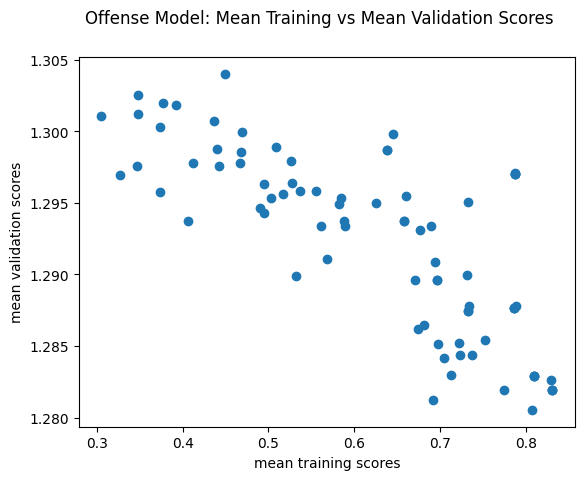

In [22]:
off_train_vs_valid_scores = train_vs_validation_scores(off_train_scores, off_val_scores)
off_train_vs_valid_scores.suptitle('Offense Model: Mean Training vs Mean Validation Scores')

Text(0.5, 0.98, 'Offense Model: Mean Training and Validation Scores\nSorted From Highest to Lowest Mean Training Score')

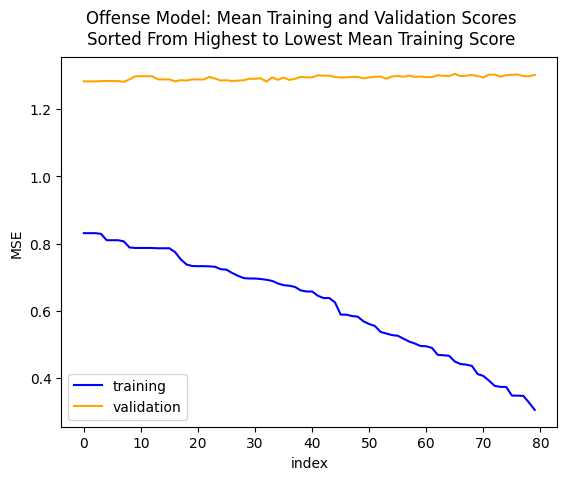

In [23]:
off_train_vs_valid_scores2 = train_vs_validation2(off_train_scores, off_val_scores)
off_train_vs_valid_scores2.suptitle('Offense Model: Mean Training and Validation Scores\nSorted From Highest to Lowest Mean Training Score')

In [42]:
get_param_with_min_val_mse(off_HP_res)

({'num_leaves': 15, 'min_data_in_leaf': 20, 'max_depth': 4}, 1.280536553239798)

In [24]:
off_train_vs_valid_scores.savefig('figures/HP_tuning_off_train_vs_valid_scores.png')

In [25]:
off_train_vs_valid_scores2.savefig('figures/HP_tuning_off_train_vs_valid_scores_sorted.png')

#### Defense

In [15]:
def_HP_res = manual_grid_search(df_for_pred, param_dist, 'Defense')

Preprocessing the inputs...
Fitting the model...
Predicting...
Calculating MSE...


===== PARAMS: {'num_leaves': 15, 'min_data_in_leaf': 5, 'max_depth': -1}, FOLD: 0, train-MSE: 0.88530, val-MSE: 1.22140 =====


Preprocessing the inputs...
Fitting the model...
Predicting...
Calculating MSE...


===== PARAMS: {'num_leaves': 15, 'min_data_in_leaf': 5, 'max_depth': -1}, FOLD: 1, train-MSE: 0.87717, val-MSE: 1.31552 =====


Preprocessing the inputs...
Fitting the model...
Predicting...
Calculating MSE...


===== PARAMS: {'num_leaves': 15, 'min_data_in_leaf': 5, 'max_depth': -1}, FOLD: 2, train-MSE: 0.89934, val-MSE: 1.20672 =====


Preprocessing the inputs...
Fitting the model...
Predicting...
Calculating MSE...


===== PARAMS: {'num_leaves': 15, 'min_data_in_leaf': 5, 'max_depth': -1}, FOLD: 3, train-MSE: 0.86928, val-MSE: 1.45029 =====


Preprocessing the inputs...
Fitting the model...
Predicting...
Calculating MSE...


===== PARAMS: {'num_leaves': 15, 'min_data_in_leaf': 5, 'max_depth':

In [6]:
# dill.dump_session('after_hp_defense.pkl')
dill.load_session('tuning_saved_session/LR_LGMB_to_Ridge/after_hp_defense.pkl')

In [26]:
def_train_scores = [x['mean_train_score'] for x in def_HP_res]
def_val_scores = [x['mean_val_score'] for x in def_HP_res]

Text(0.5, 0.98, 'Defense Model: Mean Training vs Mean Validation Scores')

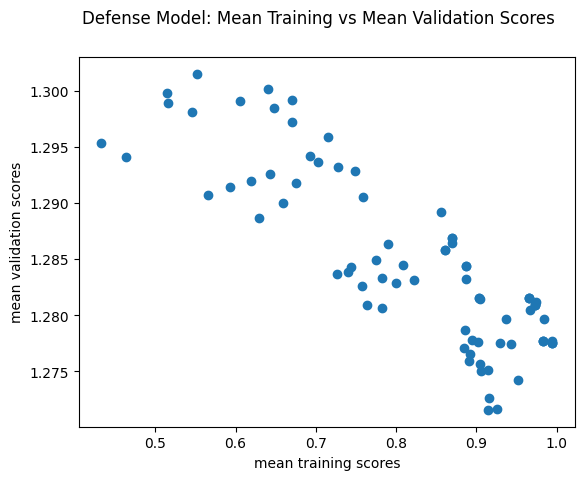

In [27]:
def_train_vs_valid_scores = train_vs_validation_scores(def_train_scores, def_val_scores)
def_train_vs_valid_scores.suptitle('Defense Model: Mean Training vs Mean Validation Scores')

Text(0.5, 0.98, 'Defense Model: Mean Training and Validation Scores\nSorted From Highest to Lowest Mean Training Score')

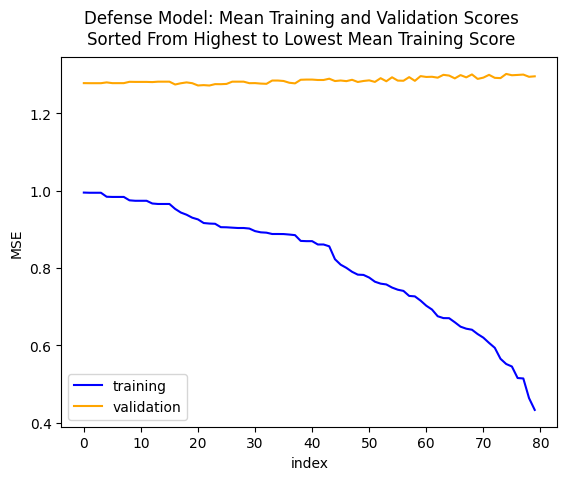

In [28]:
def_train_vs_valid_scores2 = train_vs_validation2(def_train_scores, def_val_scores)
def_train_vs_valid_scores2.suptitle('Defense Model: Mean Training and Validation Scores\nSorted From Highest to Lowest Mean Training Score')

In [43]:
get_param_with_min_val_mse(def_HP_res)

({'num_leaves': 15, 'min_data_in_leaf': 30, 'max_depth': -1},
 1.2715449829331955)

In [29]:
def_train_vs_valid_scores.savefig('figures/HP_tuning_def_train_vs_valid_scores.png')

In [30]:
def_train_vs_valid_scores2.savefig('figures/HP_tuning_def_train_vs_valid_scores_sorted.png')